## 用马尔可夫假设和mlp去预测后面点
- 马尔科夫假设
  - 下一个点的预测只与前面$\tau$个点有关，不用前面从最初开始的全部点
    - 降低预测条件要求

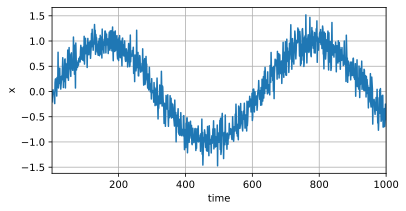

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [8]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    # 按features的列赋值，每次赋值一列
    # 把x[i:T-tau+i]个数，赋值到一列
    features[:, i] = x[i: T - tau + i]
# 第5个数开始到最后一个数都做label
labels = x[tau:].reshape((-1, 1))

# 用前600个label做训练数据
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练,截断features
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)
features

tensor([[-0.2053, -0.0956, -0.0185,  0.0331],
        [-0.0956, -0.0185,  0.0331, -0.0535],
        [-0.0185,  0.0331, -0.0535, -0.0156],
        ...,
        [-0.6161, -0.3385, -0.6896, -0.5770],
        [-0.3385, -0.6896, -0.5770, -0.2500],
        [-0.6896, -0.5770, -0.2500, -0.5565]])

In [9]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [10]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        if((epoch+1)%10==0 or epoch<10):
            print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 100, 0.01)

epoch 1, loss: 0.077773
epoch 2, loss: 0.051567
epoch 3, loss: 0.049150
epoch 4, loss: 0.047527
epoch 5, loss: 0.050215
epoch 6, loss: 0.045707
epoch 7, loss: 0.044908
epoch 8, loss: 0.050608
epoch 9, loss: 0.043998
epoch 10, loss: 0.044353
epoch 20, loss: 0.043247
epoch 30, loss: 0.047539
epoch 40, loss: 0.043195
epoch 50, loss: 0.049379
epoch 60, loss: 0.045368
epoch 70, loss: 0.042753
epoch 80, loss: 0.042029
epoch 90, loss: 0.043488
epoch 100, loss: 0.041919


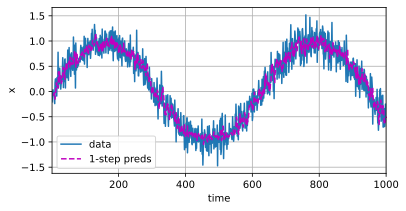

In [11]:
# 整个features都放入做预测，后400的测试也能看到，为了画出完整的图
# 但这里features的后400预测，也是用原始数据进行的预测（前四个是之前生成的）
# 而不是用模型预测的[第604,第605,第606,第607]来预测第608
# 这里的四个数据是从原始生成的X里面拿的
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

- 换成用模型预测的去预测后面的

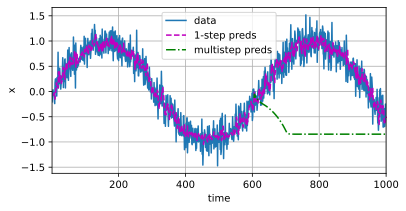

In [12]:
multistep_preds = torch.zeros(T)
# 只赋值4个
multistep_preds[: n_train + tau] = x[: n_train + tau]
# 后面的预测值也用前面的传入net生成
# 然后存在multistep_preds里面作为后面的输入-》自回归模型
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

- 可以看到上面绿色的效果很差，因为每次有一点偏差，然后偏差又进入你的数据，不断地累加，就有很大的偏差了
  
- 可以得到预测近的，比如一个点效果是不错的
- 但预测远的不好
  - 要解决的问题，怎么去预测远的点

- 基于k=1，4，16，64，通过对整个序列预测的计算， 让我们更仔细地看一下步预测的困难
  - 即k=16时，每次给16个真实数据点，去预测后面16个时间点

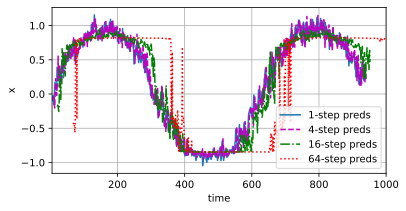

In [13]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))